# Visualization

So far we have learned how to train models for image classification, and we have evaluated their performance in terms of accuracy. But, what did these models learn? Let's try to understand that.

## Filter visualization

We will first use the model that we trained in the previous session and we will visualize the weights of the first convolutional layer. You can either use the model you trained on CIFAR in the previous session, or load the model in ```models/pretrained_cifar10.h5```.

In [1]:
from keras.models import load_model
import time

model = load_model('../models/pretrained_cifar10.h5')

Using TensorFlow backend.


In [2]:
model.layers

In [3]:
import numpy as np

# get the weights from the first layer
weights = model.layers[0].get_weights()[0] # [0] to get weights and not biases
weights.shape

(3, 3, 3, 32)

In [4]:
import matplotlib.pyplot as plt  
%matplotlib inline
from utils import *

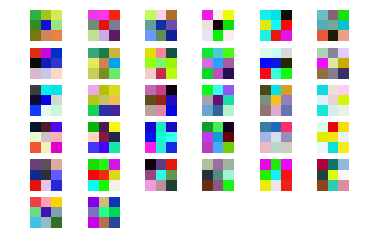

In [5]:
def display_filters(weights):
    N = int(np.ceil(np.sqrt(weights.shape[3])))
    f, axarr = plt.subplots(N, N)

    p = 0
    for i in range(N):
        for j in range(N):

            # empty plot white when out of kernels to display
            if p >= weights.shape[3]:
                krnl = np.ones((weights.shape[0],weights.shape[1],3))
            else:
                if weights.shape[2] == 3: 
                    # rgb filters converted to gray
                     #krnl = 0.21*weights[:,:,0,p] + 0.72*weights[:,:,1,p] + 0.07*weights[:,:,2,p] 
                    krnl = weights[:,:,:,p]
                    axarr[i,j].imshow(krnl)
                else:
                    krnl = np.mean(weights[:,:,:,p],axis=2)
                    axarr[i,j].imshow(krnl,cmap='gray')
            axarr[i,j].axis('off')
            p+=1
    plt.show()

display_filters(weights)

 Do you see any patterns? Maybe the filters don't say much, but we will probably understand this better if we display the activations of this filters when convolved with an an image. We will not do this right now, but it is something that you are welcome to try after the session, or on your own time.

**Exercise:** Repeat the same experiment with filters and activations from the second convolutional layer.

**Answer:** Conv2

(3, 3, 32, 32)


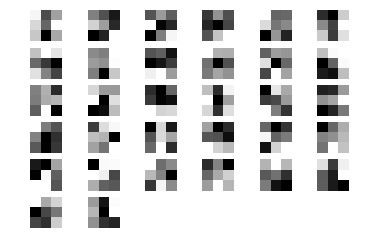

In [6]:
i = 2
weights = model.layers[i].get_weights()[0] # [0] to get weights and not biases
print (weights.shape)
display_filters(weights)

## Activations

We can also use the model's activations to our data samples to understand what the model learned. Let's first display the model to know the name of the layer we want to extract.

In [7]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 32, 32, 32)    896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_5 (Activation)        (None, 32, 32, 32)    0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 32, 32, 32)    9248        activation_5[0][0]               
____________________________________________________________________________________________________
activation_6 (Activation)        (None, 32, 32, 32)    0           convolution2d_4[0][0]            
___________________________________________________________________________________________

**Exercise:** Set ```layer_name``` to the name of the last fully connected layer before the classifier. We will use this layer as a feature extractor.

In [8]:
from keras.models import Model
layer_name = 'dense_3'
extractor = Model(input=model.input, output=model.get_layer(layer_name).output)

Once we have our extractor, we can load the data and forward it through the network to get the activations:

In [9]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [10]:
feats = extractor.predict(X_test, batch_size=32, verbose=0)
feats.shape

(10000, 128)

### Finding per unit top K samples

Let's now find the K images with highest activation for each neuron in the layer, using the original extracted activations:

In [11]:
K = 10
idxs_top10 = np.argsort(feats,axis=0)[::-1][0:K,:]

picked_samples = X_test[idxs_top10]
picked_samples.shape
#(n_images,n_units,nb_rows,nb_cols,nb_channels)

(10, 128, 32, 32, 3)

```picked_samples``` now contains the 10 images with highest activation for each neuron. Let's visualize these images for some neurons:

**Exercise:** Choose units to display their top K images. Do all units respond to distinguishable concepts? Are there units that respond to similar things?

(10, 9, 32, 32, 3)

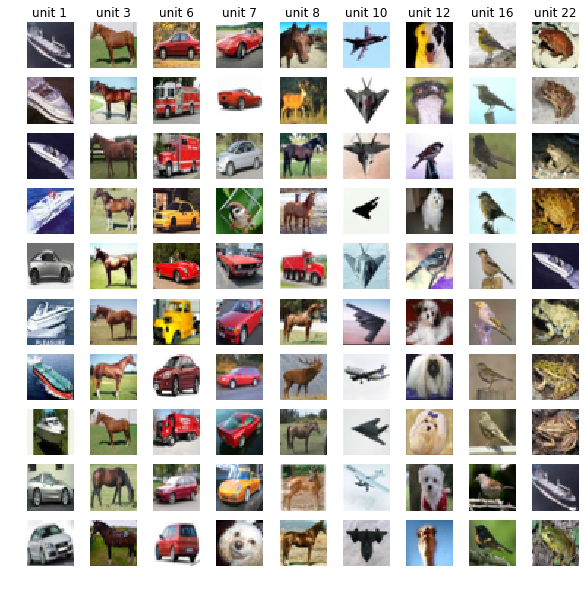

In [12]:
units = [1,3,6,7,8,10,12,16,22]
nunits = len(units)
ims = picked_samples[:,units,:,:].squeeze()

def vis_topk(ims,units):
    f, axarr = plt.subplots(ims.shape[0],ims.shape[1],figsize=(10,10))
    
    for i in range(ims.shape[0]):
        for j in range(ims.shape[1]):

            axarr[i,j].imshow(ims[i,j,:,:,:])
            axarr[i,j].axis('off')
            axarr[0,j].set_title('unit '+ str(units[j]))
            
vis_topk(ims,units)
ims.shape
#(n_ims,n_units_picked,nb_rows,nb_cols,nb_channels)

**Exercise:** Did you find any units with semantic meaning? You can try for different units and see what images they like the most.

### 1.3. Occlusion experiment

Now, can we find what image parts contribute to the activation the most? Let's create a NxN occluder and slide it through each image with a stride of 2, and feed each occluded image through the network. Then, we can obtain the difference between the activations between the original image and the occluded ones, and create a difference map that we can use as a mask on top of the image. 

In [13]:
def occ_images(ims,occ=(11,11),stride=4):
    
    import copy
    
    # Reshape to put top images for all units stacked together
    ims = np.rollaxis(ims,1,0)
    ims = np.reshape(ims,(ims.shape[0]*ims.shape[1],ims.shape[2],ims.shape[3],ims.shape[4]))
    ims_acc = ims
    
    # slide 
    npos = 1
    st = int(np.floor(occ[0]/2))
    
    # slide occluder, set pixels to 0 and stack to matrix
    for i in range(st,ims.shape[1],stride):
        for j in range(st,ims.shape[2],stride):
            ims_occ = copy.deepcopy(ims)
            ims_occ[:,i-st:i+occ[0]-st,j-st:j+occ[1]-st,:] = 0
            ims_acc = np.vstack((ims_acc,ims_occ))
            npos+=1
            
    return ims_acc

ims_acc = occ_images(ims)
print (ims_acc.shape)

(4500, 32, 32, 3)


Let's visualize some of the images with the occluded region in different positions:

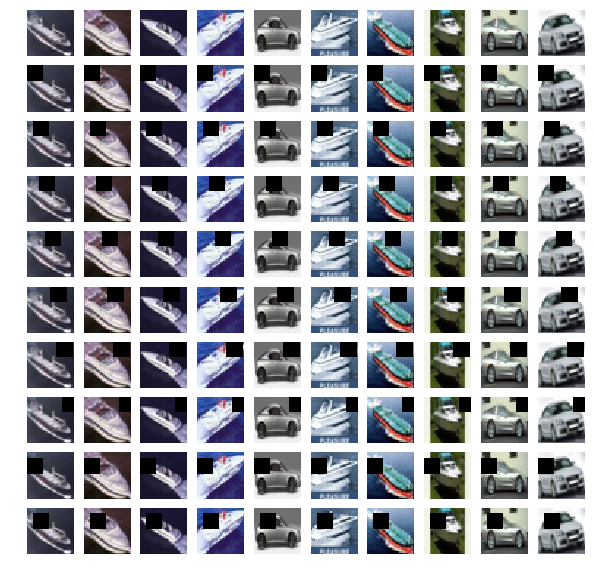

In [14]:
f, axarr = plt.subplots(10, 10,figsize=(10,10))
ims_acc_r = np.reshape(ims_acc,(int(ims_acc.shape[0]/(ims.shape[0]*ims.shape[1])),
                                ims.shape[1],ims.shape[0],
                                ims_acc.shape[1],ims_acc.shape[2],ims_acc.shape[3]))
for i in range(10):
    for j in range(10):
        axarr[i,j].imshow(ims_acc_r[i,0,j,:,:,:])
        axarr[i,j].axis('off')
plt.show()

We should pick an occluder that is large enough to cover significant parts of objects. 11x11 is the default one, but you can experiment with other sizes and see their effect.

```ims_occ``` contains all images with the occluder set at different positions. Let's run these through our extractor:

In [15]:
feats = extractor.predict(ims_acc, batch_size=32, verbose=0)
feats.shape

(4500, 128)

Now that we have the features, we can compute the difference between the original activation and the activation for each of the occluded images:

In [16]:
feats_r = np.reshape(feats,(int(feats.shape[0]/(ims.shape[0]*ims.shape[1])),
                                ims.shape[1],ims.shape[0],feats.shape[1]))

distances = feats_r[0] - feats_r[1:] # original activation minus all the occluded ones
distances = np.rollaxis(distances,0,4)

Reshaping the distance array into a 2D map will give a mask that we can display on top of the images:

In [17]:
s = int(np.sqrt(distances.shape[3]))

heatmaps = np.zeros((distances.shape[0],distances.shape[1],distances.shape[3]))
for i in range(len(units)):    
    heatmaps[i] = distances[i,:,units[i],:]
heatmaps.shape

(9, 10, 49)

Let's write a function to display the masks on top of the images:

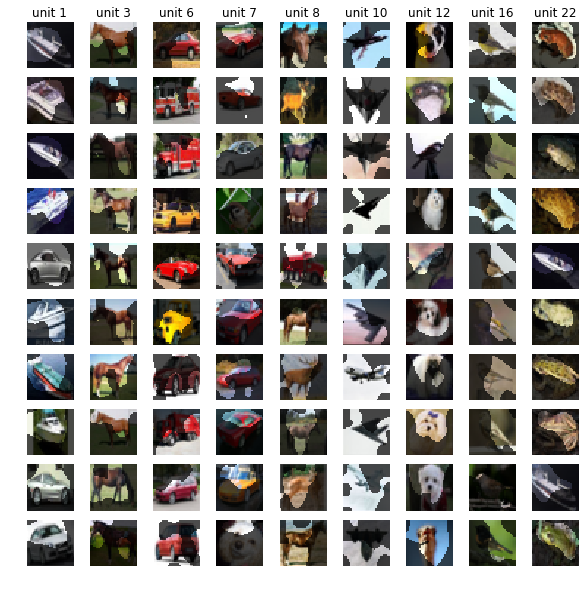

In [18]:
def vis_occ(ims,heatmaps,units,th=0.5,sig=2):
    
    from scipy.ndimage.interpolation import zoom
    from scipy.ndimage.filters import gaussian_filter
    import copy
    
    ims = np.rollaxis(ims,1,0)
    
    s = int(np.sqrt(heatmaps.shape[2]))
    heatmaps = np.reshape(heatmaps,(heatmaps.shape[0],heatmaps.shape[1],s,s))
    
    f, axarr = plt.subplots(ims.shape[1],ims.shape[0],figsize=(10,10))
    
    for i in range(ims.shape[0]):
        for j in range(ims.shape[1]):
            
            im = copy.deepcopy(ims[i,j,:,:,:])
            mask = copy.deepcopy(heatmaps[i,j,:,:])
            
            # Normalize mask
            mask = (mask - np.min(mask))/(np.max(mask)-np.min(mask))
            # Resize to image size
            mask = zoom(mask,float(im.shape[0])/heatmaps.shape[-1],order=1)
            # Apply gaussian to smooth output
            mask = gaussian_filter(mask,sigma=sig)
            # threshold to obtain mask out of heatmap
            mask[mask>=th] = 1
            mask[mask<th] = 0.3
            
            # Mask all image channels
            for c in range(3):
                im[:,:,c] = im[:,:,c]*mask
                
            axarr[j,i].imshow(im)
            axarr[j,i].axis('off')
            axarr[0,i].set_title('unit '+ str(units[i]))
            
vis_occ(ims,heatmaps,units,th=0.5)

**Exercise**: The obtained masks are of course not perfect, but we get to see what parts of the image are most relevant for each unit in the layer. In some cases though we get quite accurate segmentations of objects. Are these masks what you expected? Do the picked neurons maximally respond to what you have previously guessed?

### t-SNE

**Exercise:** The first thing we can do is display our learned features in a 2D space using t-SNE. To do this, you can use the provided function in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). You can use the provided example as reference.

In [ ]:
from sklearn.manifold import TSNE

t = time.time()

# should do more iterations, but let's do the minimum due to time constraints
n_iter = 400
tsne = TSNE(n_components=2,random_state=0,n_iter=n_iter)
feats_2d = tsne.fit_transform(feats)

print (time.time() - t)

Once we have our 2D features, we can display them with their class labels, to see if the learned features are discriminative enough.

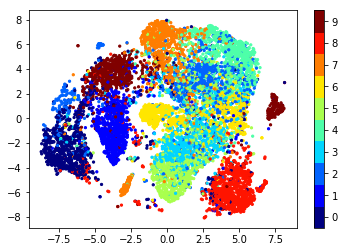

In [14]:
#cifar_labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
# 0: airplane
# 1: automobile
# 2: bird
# 3: cat
# 4: deer
# 5: dog
# 6: frog
# 7: horse
# 8: ship
# 9: truck

plt.scatter(feats_2d[:,0],feats_2d[:,1],c=y_test,cmap=plt.cm.get_cmap("jet", 10),s=5) # 10 because of the number of classes
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

**Exercise:** What categories seem to be easier for our model? Which ones are confusing?